In [61]:
import torch
import torch.nn as nn 
import pandas as pd
import numpy as np
import time
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import datetime

In [62]:
from src.algorithms.TanoGan import TanoGan
from src.model.modelTanoGan import *
from src.utils.util import *
from src.dataset.Nabdataset import NabDataset
from src.model.modelvae import *

In [63]:
#This is the beginning of programm
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)

02:17:47


<h4>Initializing Dataset</h4>

In [64]:
class ArgsTrn:
    workers=4
    batch_size=32
    epochs=5
    lr=0.0002
    cuda = True
    manualSeed=2
    mean=0
    std=0.1
    
opt_trn=ArgsTrn()
    
opt_trn=ArgsTrn()
torch.manual_seed(opt_trn.manualSeed)



class Datasettings:
    
    def __init__(self):
        '''
        end_name='ambient_temperature_system_failure.csv'
        self.dataset_name="NAB_Ambient_Temperature"
        key='realKnownCause/'+end_name 
        self.label_file = './lables/combined_windows.json'
        '''
        '''
        end_name='exchange-2_cpc_results.csv'
        self.dataset_name="exchange-2_cpc_results"
        key='realAdExchange/'+end_name 
        self.label_file = './lables/combined_windows.json'
        '''
        end_name='Twitter_volume_AAPL.csv'
        self.data_folder_path="/home/jupyter/GRANOGAN-IISC/data/nab/"
        key='realTweets/'+end_name 
        self.label_file = './lables/combined_windows.json'
        self.key=key
        self.train=True
        self.window_length=60

In [65]:
data_settings = Datasettings()
dataset = NabDataset(data_settings=data_settings)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt_trn.batch_size,
                                         shuffle=True, num_workers=int(opt_trn.workers))
seq_len = dataset.window_length # sequence length is equal to the window length
in_dim = dataset.n_feature # input dimension is same as number of feature
n_features=dataset.x.shape[2]
sequences=[x for i, (x,y) in enumerate(dataloader, 0)]

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [67]:
dataset.x.shape
embedding_dim=16

In [68]:
tanoGan=TanoGan(device=device,opt_trn=opt_trn,windows_length=seq_len,n_features=n_features,embedding_dim=embedding_dim)

In [69]:
trained_D,trained_G=tanoGan.train_TanoGAN(sequences)

/home/jupyter/src/algorithms/TanoGan.py:72: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,self.in_dim),mean=0,std=0.1)).to(self.device)
/home/jupyter/src/algorithms/TanoGan.py:88: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,self.in_dim),mean=0,std=0.1)).to(self.device)


Completed epoch 0
Completed epoch 1
Completed epoch 2
Completed epoch 3
Completed epoch 4


In [70]:
PATH_D='/home/jupyter/GRANOGAN-IISC/src/saved_models/tanogan/yahoo/dicriminator.pkl'
PATH_G='/home/jupyter/GRANOGAN-IISC/src/saved_models/tanogan/yahoo/generator.pkl'

In [71]:
torch.save(trained_D.module.state_dict(), PATH_D)
torch.save(trained_G.module.state_dict(), PATH_G)

In [72]:
state_dict = torch.load(PATH_D)
trained_D=LSTMDiscriminator(in_dim=in_dim,device=device)
trained_D=nn.DataParallel(trained_D)
trained_D.to(device)
trained_D=tanoGan.load_model(state_dict,trained_D)

state_dict = torch.load(PATH_G)
trained_G=LSTMGenerator(in_dim=in_dim, out_dim=in_dim,device=device)
trained_G=nn.DataParallel(trained_G)
trained_G.to(device)
trained_G=tanoGan.load_model(state_dict,trained_G)

<h4>Loading back the saved models</h4>

In [73]:
tanoGan.intilialize_D(trained_D)
tanoGan.intilialize_G(trained_G)

<h2>Test Data</h2>


In [74]:
class ArgsTest:
    workers = 1
    batch_size = 1
    
opt_test=ArgsTest()


class TestDataSettings:
    
    def __init__(self):
        '''
        end_name='exchange-2_cpc_results.csv'
        self.dataset_name="exchange-2_cpc_results"
        key='realAdExchange/'+end_name 
        self.label_file = './lables/combined_windows.json'
        '''
        '''
        end_name='ambient_temperature_system_failure.csv'
        self.dataset_name="NAB_Ambient_Temperature"
        key='realKnownCause/'+end_name 
        self.label_file = './lables/combined_windows.json'
        '''
        
        end_name='Twitter_volume_AAPL.csv'
        self.data_folder_path="/home/jupyter/GRANOGAN-IISC/data/nab/"
        key='realTweets/'+end_name 
        self.label_file = './lables/combined_windows.json'
        self.key=key
        self.train=False
        self.window_length=60        
        
test_data_settings = TestDataSettings()

In [75]:
# define dataset object and data loader object in evaluation mood for NAB dataset
test_dataset = NabDataset(test_data_settings)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=opt_test.batch_size, 
                                         shuffle=False, num_workers=int(opt_test.workers))

test_dataset.x.shape, test_dataset.y.shape, test_dataset.data_len # check the dataset shape


test_sequences=[x for i, (x,y) in enumerate(test_dataloader, 0)]

In [76]:
losses=tanoGan.predict_loss(test_sequences,opt_test.batch_size)

/home/jupyter/src/algorithms/TanoGan.py:118: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  z = Variable(init.normal(torch.zeros(batch_size,
/libraries/Default_env_55311/lib/python3.8/site-packages/torch/nn/parallel/comm.py:231: UserWarning: Using -1 to represent CPU tensor is deprecated. Please use a device object or string instead, e.g., "cpu".
  warnings.warn(


In [77]:
import matplotlib.pyplot as plt
import seaborn as sns


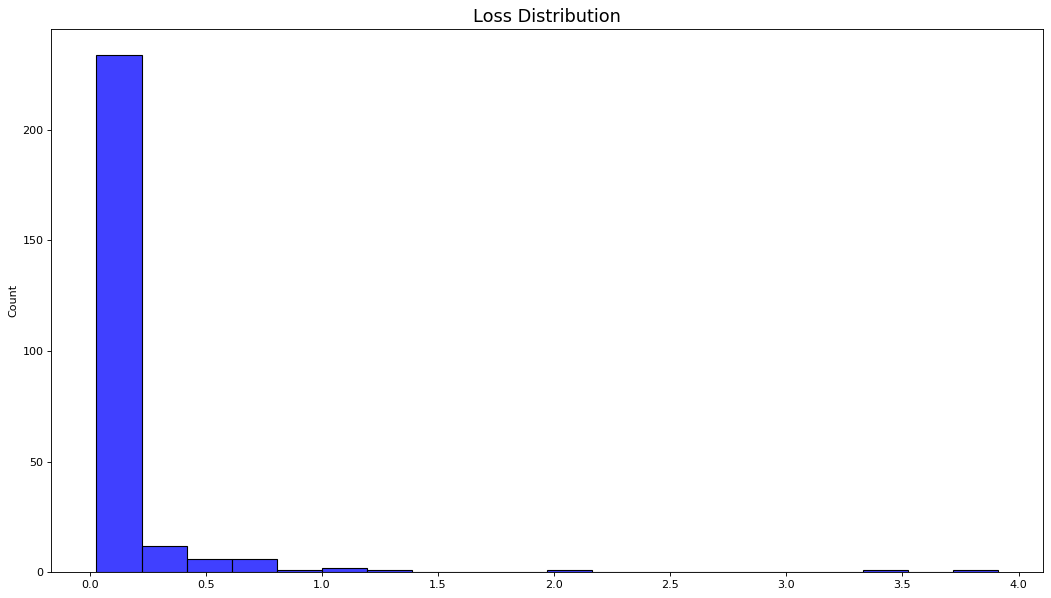

In [78]:

plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.histplot([loss.item()/60 for loss in losses], bins = 20, kde= False, color = 'blue');
#sns.distplot(losses, bins = 20, kde= True, color = 'blue');

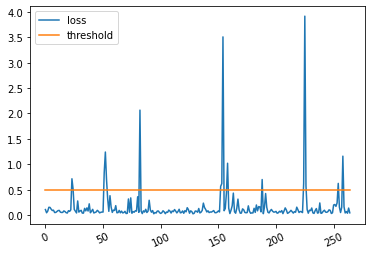

In [82]:
THRESHOLD =0.5

test_score_df = pd.DataFrame(index=range(len(losses)))
test_score_df['loss'] = [loss.item()/60 for loss in losses]
test_score_df['y'] = test_dataset.y
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['t'] = [x[59].item() for x in test_dataset.x]

plt.plot( test_score_df.loss, label='loss')
plt.plot( test_score_df.threshold, label='threshold')
#plt.plot( test_score_df.y, label='y')
plt.xticks(rotation=25)
plt.legend();

In [83]:
import numpy as np
actual,predicted=improve_detection(test_score_df)

In [84]:

from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

predicted = np.array(predicted)
actual = np.array(actual)

print_scores(predicted,actual)

True Positive	 31
True Negative	 224
False Positive	 10
False Negative	 0
Accuracy	 0.9622641509433962
Precision	 0.7560975609756098
Recall	 1.0
f-measure	 0.8611111111111112
cohen_kappa_score	 0.8397629701293989
auc	 0.9786324786324787
roc_auc	 0.9786324786324787
